In [55]:
import tensorflow as tf
import os
import gzip
import matplotlib.pyplot as plt
import numpy as np
import _pickle as cPickle
plt.ion()

Data Loading

In [56]:
#loading data
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

In [57]:
#separating data into trainining, validation and test dataset
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval

n_train_samples = X_train.shape[0]
train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]

... loading data
... done loading data


In [58]:
"""
SKELETON
def model_fn(features, labels, mode, params):
   # Logic to do the following:
   # 1. Configure the model via TensorFlow operations
   # 2. Define the loss function for training/evaluation
   # 3. Define the training operation/optimizer
   # 4. Generate predictions
   # 5. Return predictions/loss/train_op/eval_metric_ops in EstimatorSpec object
   return EstimatorSpec(mode, predictions, loss, train_op, eval_metric_ops)
"""

def cnn(features, labels, mode, params):
    
    num_filters, learning_rate = params["num_filters"], params["learning_rate"]
    
    #1. network architecture
    # Input Layer
    inputs = tf.reshape(features["x"], [-1, 28, 28, 1])

    # 1st layer
    cl_1 = tf.layers.conv2d(inputs, filters=num_filters, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool_cl1 = tf.layers.max_pooling2d(inputs=cl_1, pool_size=[2, 2], strides=1)

    # 2nd layer
    cl_2 = tf.layers.conv2d(pool_cl1, filters=num_filters, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool_cl2 = tf.layers.max_pooling2d(cl_2, pool_size=[2, 2], strides=1)

    # fully connected
    pool_cl2_flat = tf.reshape(pool_cl2, [-1, 26 * 26 * num_filters])
    dense = tf.layers.dense(pool_cl2_flat, units=128)
    dropout = tf.layers.dropout(dense, rate=0.5) 
    
    # output layer
    output = tf.layers.dense(inputs=dropout, units=10)
    
    
    #2. calculate losses cross entropy with sgd for training and evaluation
    onehot_y = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    cross_entropy_loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_y, logits=output)
    
    #3. define the training operation/optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train_step = optimizer.minimize(loss=cross_entropy_loss, global_step=tf.train.get_global_step())    
        return tf.estimator.EstimatorSpec(mode=mode, loss=cross_entropy_loss, train_op=train_step)
    
    #4. generate predictions
    predictions = tf.argmax(input=output, axis=1)
    """"
    predictions = {
    "classes": tf.argmax(input=output, axis=1),
    "probabilities": tf.nn.softmax(output, name="softmax_tensor")}"""

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
        
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions)}
    specs = tf.estimator.EstimatorSpec(mode=mode, loss=cross_entropy_loss, eval_metric_ops=eval_metric_ops)
    return specs    

In [59]:
filter_nums = [8, 16, 32, 64, 128, 256]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
default_filter = 16
default_rate = 0.01
max_epochs = 20
batch_size = 500

In [60]:
def train(X_train, y_train, X_valid, y_valid, learning_rate, batch_size, max_epochs, filter_nums):
    val_errs = np.zeros(max_epochs)
    #Initializing estimator
    mnist_model = tf.estimator.Estimator(cnn, params = {"num_filters": filter_nums, "learning_rate": learning_rate})
    #valid_loss = np.zeros(max_epochs)
    #data_storage =[]   
    for epoch in range(1, max_epochs+1):
        #training 
        train_input_fn = tf.estimator.inputs.numpy_input_fn(
            x = {"x": X_train}, y = y_train,
            batch_size = batch_size, num_epochs = None, 
            shuffle = True)
        mnist_model.train(train_input_fn, steps = X_train.shape[0]/batch_size)

        #evaluation
        eval_input_fn = tf.estimator.inputs.numpy_input_fn(
            x = {"x": X_valid},y = y_valid,
            batch_size = batch_size,
            shuffle = False)
        evaluator = mnist_model.evaluate(eval_input_fn)
        val_errs[epoch-1] = 1.-evaluator['accuracy']
        print("Epoch: {}, Validation error: {:.4f}, Learning rate: {:.4f}".format(epoch, 1.-evaluator['accuracy'], learning_rate))
    return val_errs

In [61]:
import time

val_errs = np.zeros((len(learning_rates),max_epochs))
for idx,rate in enumerate(learning_rates):
    t0 = time.time()
    val_errs[idx] = train(X_train,y_train,X_valid,y_valid, rate, batch_size, max_epochs, default_filter)
    t1 = time.time()
    print('Duration: {:.1f}s'.format(t1-t0))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Hakan\\AppData\\Local\\Temp\\tmp34_7jis8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001CC01224D30>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt.
INFO:tensorflow:loss = 2.29072, step = 1
INFO:tensorflow:Saving checkpoints for 100 into C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt.
INFO:tensorflow:Loss for final step: 0.428524.
INFO:tensorflow:Starting evaluation at 2

INFO:tensorflow:Saving checkpoints for 901 into C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt.
INFO:tensorflow:loss = 0.267008, step = 901
INFO:tensorflow:Saving checkpoints for 1000 into C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt.
INFO:tensorflow:Loss for final step: 0.068857.
INFO:tensorflow:Starting evaluation at 2017-11-21-22:25:51
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2017-11-21-22:26:00
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9763, global_step = 1000, loss = 0.0795304
Epoch: 10, Validation error: 0.0237, Learning rate: 0.1000
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt-1000
INFO:tensorflow:Saving checkpoints for 1001 into C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt.
INFO:tensorflow:loss = 0.0928415, step = 1001
INFO:ten

Epoch: 19, Validation error: 0.0158, Learning rate: 0.1000
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt-1900
INFO:tensorflow:Saving checkpoints for 1901 into C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt.
INFO:tensorflow:loss = 0.0578713, step = 1901
INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt.
INFO:tensorflow:Loss for final step: 0.0359938.
INFO:tensorflow:Starting evaluation at 2017-11-21-22:50:33
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmp34_7jis8\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-11-21-22:50:44
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9831, global_step = 2000, loss = 0.0563891
Epoch: 20, Validation error: 0.0169, Learning rate: 0.1000
Duration: 3024.4s
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir

INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpvz46kow9\model.ckpt-800
INFO:tensorflow:Saving checkpoints for 801 into C:\Users\Hakan\AppData\Local\Temp\tmpvz46kow9\model.ckpt.
INFO:tensorflow:loss = 0.262075, step = 801
INFO:tensorflow:Saving checkpoints for 900 into C:\Users\Hakan\AppData\Local\Temp\tmpvz46kow9\model.ckpt.
INFO:tensorflow:Loss for final step: 0.285934.
INFO:tensorflow:Starting evaluation at 2017-11-21-23:16:00
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpvz46kow9\model.ckpt-900
INFO:tensorflow:Finished evaluation at 2017-11-21-23:16:11
INFO:tensorflow:Saving dict for global step 900: accuracy = 0.9315, global_step = 900, loss = 0.241227
Epoch: 9, Validation error: 0.0685, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpvz46kow9\model.ckpt-900
INFO:tensorflow:Saving checkpoints for 901 into C:\Users\Hakan\Ap

Epoch: 18, Validation error: 0.0359, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpvz46kow9\model.ckpt-1800
INFO:tensorflow:Saving checkpoints for 1801 into C:\Users\Hakan\AppData\Local\Temp\tmpvz46kow9\model.ckpt.
INFO:tensorflow:loss = 0.114488, step = 1801
INFO:tensorflow:Saving checkpoints for 1900 into C:\Users\Hakan\AppData\Local\Temp\tmpvz46kow9\model.ckpt.
INFO:tensorflow:Loss for final step: 0.147582.
INFO:tensorflow:Starting evaluation at 2017-11-21-23:43:46
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpvz46kow9\model.ckpt-1900
INFO:tensorflow:Finished evaluation at 2017-11-21-23:43:57
INFO:tensorflow:Saving dict for global step 1900: accuracy = 0.966, global_step = 1900, loss = 0.129864
Epoch: 19, Validation error: 0.0340, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\A

INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmphbt5sszj\model.ckpt-700
INFO:tensorflow:Saving checkpoints for 701 into C:\Users\Hakan\AppData\Local\Temp\tmphbt5sszj\model.ckpt.
INFO:tensorflow:loss = 0.460103, step = 701
INFO:tensorflow:Saving checkpoints for 800 into C:\Users\Hakan\AppData\Local\Temp\tmphbt5sszj\model.ckpt.
INFO:tensorflow:Loss for final step: 0.47499.
INFO:tensorflow:Starting evaluation at 2017-11-22-00:08:50
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmphbt5sszj\model.ckpt-800
INFO:tensorflow:Finished evaluation at 2017-11-22-00:09:03
INFO:tensorflow:Saving dict for global step 800: accuracy = 0.8896, global_step = 800, loss = 0.382247
Epoch: 8, Validation error: 0.1104, Learning rate: 0.0010
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmphbt5sszj\model.ckpt-800
INFO:tensorflow:Saving checkpoints for 801 into C:\Users\Hakan\App

Epoch: 17, Validation error: 0.0913, Learning rate: 0.0010
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmphbt5sszj\model.ckpt-1700
INFO:tensorflow:Saving checkpoints for 1701 into C:\Users\Hakan\AppData\Local\Temp\tmphbt5sszj\model.ckpt.
INFO:tensorflow:loss = 0.393239, step = 1701
INFO:tensorflow:Saving checkpoints for 1800 into C:\Users\Hakan\AppData\Local\Temp\tmphbt5sszj\model.ckpt.
INFO:tensorflow:Loss for final step: 0.321428.
INFO:tensorflow:Starting evaluation at 2017-11-22-00:37:11
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmphbt5sszj\model.ckpt-1800
INFO:tensorflow:Finished evaluation at 2017-11-22-00:37:21
INFO:tensorflow:Saving dict for global step 1800: accuracy = 0.9093, global_step = 1800, loss = 0.31278
Epoch: 18, Validation error: 0.0907, Learning rate: 0.0010
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\A

INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpnl9dgtah\model.ckpt-600
INFO:tensorflow:Saving checkpoints for 601 into C:\Users\Hakan\AppData\Local\Temp\tmpnl9dgtah\model.ckpt.
INFO:tensorflow:loss = 2.09176, step = 601
INFO:tensorflow:Saving checkpoints for 700 into C:\Users\Hakan\AppData\Local\Temp\tmpnl9dgtah\model.ckpt.
INFO:tensorflow:Loss for final step: 2.06878.
INFO:tensorflow:Starting evaluation at 2017-11-22-00:58:20
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpnl9dgtah\model.ckpt-700
INFO:tensorflow:Finished evaluation at 2017-11-22-00:58:29
INFO:tensorflow:Saving dict for global step 700: accuracy = 0.4966, global_step = 700, loss = 2.05355
Epoch: 7, Validation error: 0.5034, Learning rate: 0.0001
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpnl9dgtah\model.ckpt-700
INFO:tensorflow:Saving checkpoints for 701 into C:\Users\Hakan\AppDa

INFO:tensorflow:Saving dict for global step 1600: accuracy = 0.7196, global_step = 1600, loss = 1.66177
Epoch: 16, Validation error: 0.2804, Learning rate: 0.0001
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpnl9dgtah\model.ckpt-1600
INFO:tensorflow:Saving checkpoints for 1601 into C:\Users\Hakan\AppData\Local\Temp\tmpnl9dgtah\model.ckpt.
INFO:tensorflow:loss = 1.67865, step = 1601
INFO:tensorflow:Saving checkpoints for 1700 into C:\Users\Hakan\AppData\Local\Temp\tmpnl9dgtah\model.ckpt.
INFO:tensorflow:Loss for final step: 1.62807.
INFO:tensorflow:Starting evaluation at 2017-11-22-08:32:25
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpnl9dgtah\model.ckpt-1700
INFO:tensorflow:Finished evaluation at 2017-11-22-08:32:36
INFO:tensorflow:Saving dict for global step 1700: accuracy = 0.732, global_step = 1700, loss = 1.60355
Epoch: 17, Validation error: 0.2680, Learning rate: 0.0001
I

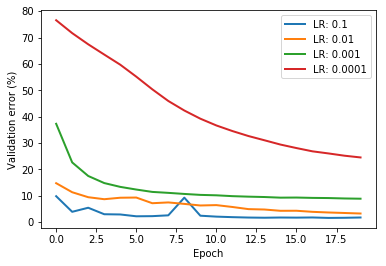

In [66]:
# Plot learning curves for different values of the learning rate
learning_fig = plt.figure()
for idx in range(learning_data.shape[0]):
    plt.plot(val_errs[idx,:]*100,LineWidth=2,label='LR: '+str(learning_rates[idx]))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation error (%)')
plt.savefig("Learning_curves.png")

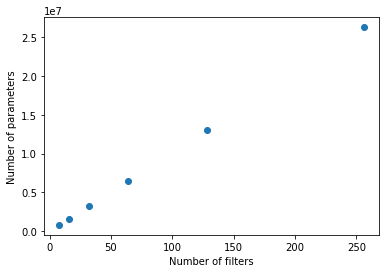

In [63]:
# Plot parameter nums over filter nums
filter_nums = np.array(filter_nums)
parameter_nums = filter_nums*(3*3+1) + filter_nums*(3*3*filter_nums+1) + 128*(28*28*filter_nums+1)

parameter_num_fig = plt.figure()
plt.scatter(filter_nums,parameter_nums)
plt.xlabel('Number of filters')
plt.ylabel('Number of parameters')
plt.savefig('Num_Parameters_over_Num_Filters.png')

In [64]:
# Train network with different filter nums and log training time
run_times = np.zeros(len(filter_nums[0:4]))
for idx,filter_num in enumerate(filter_nums[0:4]):
    t0 = time.time()
    train(X_train,y_train,X_valid,y_valid, default_rate, batch_size, max_epochs, filter_num)
    t1 = time.time()
    run_times[idx] = t1-t0
    print('Duration: {:.1f}s'.format(t1-t0))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Hakan\\AppData\\Local\\Temp\\tmp547t3z72', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001CC01AA9A90>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt.
INFO:tensorflow:loss = 2.30712, step = 1
INFO:tensorflow:Saving checkpoints for 100 into C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt.
INFO:tensorflow:Loss for final step: 0.607555.
INFO:tensorflow:Starting evaluation at 2

INFO:tensorflow:Saving checkpoints for 901 into C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt.
INFO:tensorflow:loss = 0.28517, step = 901
INFO:tensorflow:Saving checkpoints for 1000 into C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt.
INFO:tensorflow:Loss for final step: 0.298886.
INFO:tensorflow:Starting evaluation at 2017-11-22-08:52:59
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2017-11-22-08:53:05
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9237, global_step = 1000, loss = 0.263774
Epoch: 10, Validation error: 0.0763, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt-1000
INFO:tensorflow:Saving checkpoints for 1001 into C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt.
INFO:tensorflow:loss = 0.21976, step = 1001
INFO:tensorf

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt-1900
INFO:tensorflow:Saving checkpoints for 1901 into C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt.
INFO:tensorflow:loss = 0.181732, step = 1901
INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt.
INFO:tensorflow:Loss for final step: 0.14037.
INFO:tensorflow:Starting evaluation at 2017-11-22-09:06:13
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmp547t3z72\model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2017-11-22-09:06:18
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9608, global_step = 2000, loss = 0.151252
Epoch: 20, Validation error: 0.0392, Learning rate: 0.0100
Duration: 1598.5s
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Hakan\\AppData\\Local\\Temp\\tmph1j93kvn', '_tf_

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmph1j93kvn\model.ckpt-800
INFO:tensorflow:Saving checkpoints for 801 into C:\Users\Hakan\AppData\Local\Temp\tmph1j93kvn\model.ckpt.
INFO:tensorflow:loss = 0.247756, step = 801
INFO:tensorflow:Saving checkpoints for 900 into C:\Users\Hakan\AppData\Local\Temp\tmph1j93kvn\model.ckpt.
INFO:tensorflow:Loss for final step: 0.218529.
INFO:tensorflow:Starting evaluation at 2017-11-22-10:00:03
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmph1j93kvn\model.ckpt-900
INFO:tensorflow:Finished evaluation at 2017-11-22-10:00:12
INFO:tensorflow:Saving dict for global step 900: accuracy = 0.9398, global_step = 900, loss = 0.210462
Epoch: 9, Validation error: 0.0602, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmph1j93kvn\model.ckpt-900
INFO:tensorflow:Savin

INFO:tensorflow:Saving dict for global step 1800: accuracy = 0.9687, global_step = 1800, loss = 0.120149
Epoch: 18, Validation error: 0.0313, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmph1j93kvn\model.ckpt-1800
INFO:tensorflow:Saving checkpoints for 1801 into C:\Users\Hakan\AppData\Local\Temp\tmph1j93kvn\model.ckpt.
INFO:tensorflow:loss = 0.104463, step = 1801
INFO:tensorflow:Saving checkpoints for 1900 into C:\Users\Hakan\AppData\Local\Temp\tmph1j93kvn\model.ckpt.
INFO:tensorflow:Loss for final step: 0.104402.
INFO:tensorflow:Starting evaluation at 2017-11-22-10:22:19
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmph1j93kvn\model.ckpt-1900
INFO:tensorflow:Finished evaluation at 2017-11-22-10:22:28
INFO:tensorflow:Saving dict for global step 1900: accuracy = 0.97, global_step = 1900, loss = 0.114811
Epoch: 19, Validation error: 0.0300, Learning rate: 0.010

Epoch: 7, Validation error: 0.0666, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpwwa1e309\model.ckpt-700
INFO:tensorflow:Saving checkpoints for 701 into C:\Users\Hakan\AppData\Local\Temp\tmpwwa1e309\model.ckpt.
INFO:tensorflow:loss = 0.26679, step = 701
INFO:tensorflow:Saving checkpoints for 800 into C:\Users\Hakan\AppData\Local\Temp\tmpwwa1e309\model.ckpt.
INFO:tensorflow:Loss for final step: 0.243022.
INFO:tensorflow:Starting evaluation at 2017-11-22-11:02:32
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpwwa1e309\model.ckpt-800
INFO:tensorflow:Finished evaluation at 2017-11-22-11:02:50
INFO:tensorflow:Saving dict for global step 800: accuracy = 0.9382, global_step = 800, loss = 0.221242
Epoch: 8, Validation error: 0.0618, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Lo

INFO:tensorflow:Finished evaluation at 2017-11-22-11:46:08
INFO:tensorflow:Saving dict for global step 1700: accuracy = 0.9704, global_step = 1700, loss = 0.120722
Epoch: 17, Validation error: 0.0296, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpwwa1e309\model.ckpt-1700
INFO:tensorflow:Saving checkpoints for 1701 into C:\Users\Hakan\AppData\Local\Temp\tmpwwa1e309\model.ckpt.
INFO:tensorflow:loss = 0.134783, step = 1701
INFO:tensorflow:Saving checkpoints for 1800 into C:\Users\Hakan\AppData\Local\Temp\tmpwwa1e309\model.ckpt.
INFO:tensorflow:Loss for final step: 0.0823659.
INFO:tensorflow:Starting evaluation at 2017-11-22-11:50:34
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpwwa1e309\model.ckpt-1800
INFO:tensorflow:Finished evaluation at 2017-11-22-11:50:52
INFO:tensorflow:Saving dict for global step 1800: accuracy = 0.9704, global_step = 1800, loss = 0.11

INFO:tensorflow:Saving checkpoints for 501 into C:\Users\Hakan\AppData\Local\Temp\tmpiaoqgp3u\model.ckpt.
INFO:tensorflow:loss = 0.294284, step = 501
INFO:tensorflow:Saving checkpoints for 590 into C:\Users\Hakan\AppData\Local\Temp\tmpiaoqgp3u\model.ckpt.
INFO:tensorflow:Saving checkpoints for 600 into C:\Users\Hakan\AppData\Local\Temp\tmpiaoqgp3u\model.ckpt.
INFO:tensorflow:Loss for final step: 0.252044.
INFO:tensorflow:Starting evaluation at 2017-11-22-13:12:56
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpiaoqgp3u\model.ckpt-600
INFO:tensorflow:Finished evaluation at 2017-11-22-13:13:40
INFO:tensorflow:Saving dict for global step 600: accuracy = 0.9239, global_step = 600, loss = 0.259714
Epoch: 6, Validation error: 0.0761, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpiaoqgp3u\model.ckpt-600
INFO:tensorflow:Saving checkpoints for 601 into C:\Users\Hakan

Epoch: 14, Validation error: 0.0389, Learning rate: 0.0100
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpiaoqgp3u\model.ckpt-1400
INFO:tensorflow:Saving checkpoints for 1401 into C:\Users\Hakan\AppData\Local\Temp\tmpiaoqgp3u\model.ckpt.
INFO:tensorflow:loss = 0.179707, step = 1401
INFO:tensorflow:Saving checkpoints for 1480 into C:\Users\Hakan\AppData\Local\Temp\tmpiaoqgp3u\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1500 into C:\Users\Hakan\AppData\Local\Temp\tmpiaoqgp3u\model.ckpt.
INFO:tensorflow:Loss for final step: 0.170017.
INFO:tensorflow:Starting evaluation at 2017-11-22-15:18:14
INFO:tensorflow:Restoring parameters from C:\Users\Hakan\AppData\Local\Temp\tmpiaoqgp3u\model.ckpt-1500
INFO:tensorflow:Finished evaluation at 2017-11-22-15:19:00
INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.9625, global_step = 1500, loss = 0.141013
Epoch: 15, Validation error: 0.0375, Learning rate: 0

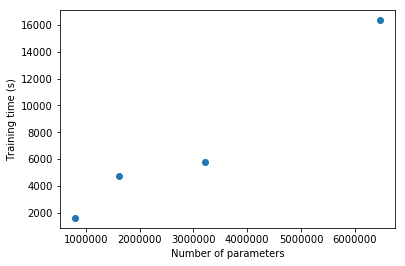

In [65]:
# Plot training times over parameter nums
runtime_fig = plt.figure()
plt.scatter(parameter_nums[0:4],run_times)
plt.xlabel('Number of parameters')
plt.ylabel('Training time (s)')
plt.savefig('Runtimes_CPU.png')

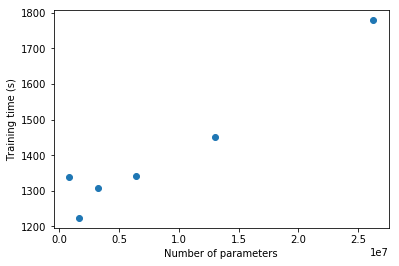

In [67]:
# GPU comparison (data from Maryna Kapitonova)
run_times_GPU = np.array([22.29817223548889,20.40159320831299,21.783048152923584,22.34057903289795,24.202468633651733,
29.6546893119812])*60
runtime_fig = plt.figure()
plt.scatter(parameter_nums,run_times_GPU)
plt.xlabel('Number of parameters')
plt.ylabel('Training time (s)')
plt.savefig('Runtimes_GPU.png')